In [1]:
import os

import matplotlib.dates as mdates
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import scipy.stats as ss
from sklearn.decomposition import PCA
from tqdm.notebook import tqdm

In [2]:
# Обучение проводим включительно по эту дату
split_date = "2020-12-30"

In [3]:
interest_rates = ["cbr_g_curve"]
currencies = ["USD", "CHF"]
indexes = ["BRENT", "GOLD", "IMOEX", "RTSI"]
stocks = [
    "APTK",
    "BELU",
    "FESH",
    "MVID",
    "NKNCP",
    "PHOR",
    "PIKK",
    "RASP",
    "SELG",
    "SNGSP",
]
bonds = [
    "OFZ_26207",
    "OFZ_26209",
    "OFZ_26211",
    "OFZ_26212",
    "OFZ_26218",
]
instruments = stocks + bonds

In [4]:
def concat_data(files):
    df = []
    for file in files:
        df.append(pd.read_csv(file))
    dfs = df[0]
    for x in df[1:]:
        dfs = pd.merge(dfs, x, on=["Date"], how="outer")

    dfs = dfs[(dfs["Date"] >= "2016-01-01") & (dfs["Date"] < "2022-01-01")].copy()
    dfs.set_index("Date", inplace=True)
    dfs.sort_index(inplace=True)
    dfs.index = pd.to_datetime(dfs.index)
    # dfs.dropna(inplace=True)
    return dfs.copy()

In [5]:
path = "./data/{}.csv"
df_risk = [path.format(x) for x in interest_rates + currencies + indexes]
df_risk = concat_data(df_risk)

df_tools = [path.format(x) for x in instruments]
df_tools = concat_data(df_tools)

common_index = pd.merge(df_risk, df_tools, on=["Date"], how="outer").dropna().index
df_risk = df_risk.loc[common_index].copy()
df_tools = df_tools.loc[common_index].copy()

df = pd.merge(df_risk, df_tools, on=["Date"], how="outer")
features_risk = list(df_risk.columns)
features_tools = list(df_tools.columns) + currencies
print(len(df), len(df_risk), len(df_tools))

1109 1109 1109


In [6]:
train_df = df[df.index <= split_date].pct_change().dropna(axis=0)
test_df = df[df.index > split_date].pct_change().dropna(axis=0)
all_df = df.pct_change().dropna(axis=0)

In [7]:
import optuna
from sklearn.decomposition import PCA
from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score
from sklearn.model_selection import TimeSeriesSplit

optuna.logging.set_verbosity(optuna.logging.ERROR)


def get_values(x):
    if isinstance(x, (pd.DataFrame, pd.Series)):
        return x.values
    return x


class Model:
    def __init__(self, n_components=None, pca_args=None, lr_args=None):
        self.pca_args = pca_args or {"random_state": 42}
        self.lr_args = lr_args or {}
        self.n_components = n_components
        self.pca = n_components and PCA(n_components, **self.pca_args)
        self.lr = LinearRegression(**self.lr_args)

    def fit(self, data, target):
        data = get_values(data)
        target = get_values(target)
        if self.pca:
            data = self.pca.fit_transform(data)
        self.lr.fit(data, target)
        return self

    def predict_pca(self, data):
        data = get_values(data)
        if self.pca:
            return self.pca.transform(data)
        return data

    def predict_lr(self, data):
        return self.lr.predict(data)

    def predict(self, data):
        data = self.predict_pca(data)
        return self.predict_lr(data)

    def __repr__(self):
        return "{}({}, {})".format(self.__class__.__name__, self.pca, self.lr)


class AutoModel:
    def __init__(self, cv_splits=5, n_trials=10, max_components=10, metric=None):
        self.splitter = TimeSeriesSplit(cv_splits)
        self.study = optuna.study.create_study(sampler=optuna.samplers.TPESampler(seed=42), direction="maximize")
        self.metric = metric or r2_score
        self.n_trials = n_trials
        self.max_components = max_components

    def fit(self, data, target):
        data = get_values(data)
        target = get_values(target)

        def objective(trial):
            components = trial.suggest_int("n_components", 2, min([self.max_components, *data.shape]))
            for t in trial.study.trials:
                if t.state != optuna.trial.TrialState.COMPLETE:
                    continue
                if t.params == trial.params:
                    raise optuna.exceptions.TrialPruned("Duplicate parameter set")

            scores = []
            for train_idx, test_idx in self.splitter.split(data):
                model = Model(components)
                model.fit(data[train_idx], target[train_idx])
                proba = model.predict(data[test_idx])
                score = self.metric(target[test_idx], proba)
                scores.append(score)
            return np.mean(scores)

        self.study.optimize(objective, self.n_trials)
        return Model(**self.study.best_params).fit(data, target)

In [8]:
results = []
instrument_models = {}

for f in features_tools:
    if f in stocks:
        m = Model()
    else:
        m = AutoModel()
    m = m.fit(train_df[features_risk], train_df[f])
    score = m.predict(train_df[features_risk])
    score_test = m.predict(test_df[features_risk])
    results.append(
        {
            "tool": f,
            "n_components": m.n_components,
            "r2_train": r2_score(train_df[f], score),
            "r2_test": r2_score(test_df[f], score_test),
        }
    )
    instrument_models[f] = m
results = pd.DataFrame(results)
results

,tool,n_components,r2_train,r2_test
0,APTK,NaN,0.044904,-0.139205
1,BELU,NaN,0.031068,-0.007992
2,FESH,NaN,0.109753,-0.110268
3,MVID,NaN,0.039271,-0.074765
4,NKNCP,NaN,0.059175,-0.015038
5,PHOR,NaN,0.146426,0.002186
6,PIKK,NaN,0.059861,0.011899
7,RASP,NaN,0.179363,0.012592
8,SELG,NaN,0.074071,-0.077078
9,SNGSP,NaN,0.174111,-0.105762


In [9]:
import copy


class Instrument:
    def __init__(self, name, count, price):
        self.name = name
        self.cnt = count
        self.price = price

    @property
    def cost(self):
        return self.price * self.cnt

    def __repr__(self):
        return "{}({} x {})".format(self.name, self.cnt, self.price)


class Portfolio:
    def __init__(self, tools_with_money, init_prices):
        total = sum(tools_with_money.values())
        self.tools_target = {k: v / total for k, v in tools_with_money.items()}
        self.tools = {
            k: Instrument(k, tools_with_money[k] / init_prices[k], init_prices[k]) for k, v in self.tools_target.items()
        }

    @property
    def cost(self):
        return sum([x.cost for x in self.tools.values()])

    def _tool_rate(self):
        total_cost = self.cost
        return {k: v.cost / total_cost for k, v in self.tools.items()}

    def __getitem__(self, k):
        return self.tools[k]

    def rebalancing(self, new_prices):
        old_cost = self.cost
        old_prices = {k: self[k].price for k in self.tools}
        for k, p in new_prices.items():
            self[k].price = p
        new_cost = self.cost
        for k in self.tools:
            self[k].cnt *= new_cost / old_cost * old_prices[k] / new_prices[k]

        for k, v in self._tool_rate().items():
            assert np.abs(v - self.tools_target[k]) < 0.00001

    def new_cost(self, new_prices):
        new_cost = sum([v.cnt * new_prices[k] for k, v in self.tools.items()])
        return new_cost

    def copy(self):
        return copy.deepcopy(self)

In [10]:
def get_step_simulations(data, t, rounds=1000, random_state=42):
    """
    Симуляция процентного приращения риск-фактора на t шагов вперед
    """
    rnd = np.random.RandomState(random_state)
    corr_matrix = np.linalg.cholesky(np.corrcoef(data, rowvar=False))
    rnd_vec = (
        corr_matrix
        @ np.cumsum(np.sqrt(1 / t) * rnd.normal(loc=0, scale=1, size=(data.shape[1], rounds, t)), axis=2)[:, :, -1]
    )
    # здесь вычисляется процентное приращение риск-фактора
    new_vals = np.exp((data.mean(axis=0) - data.std(axis=0) ** 2 / 2) / t + data.std(axis=0) * rnd_vec.T) - 1
    return new_vals


def semaphore(p):
    if p > 0.05:
        return "green"
    elif p > 0.0001:
        return "yellow"
    else:
        return "red"


def norm_percenile(x, level):
    return np.mean(x) + ss.norm.ppf(level) * np.std(x)

In [11]:
class PortfolioSimulation:
    def __init__(self, init_tools, window_size, t):
        features_tools = sorted(list(init_tools.keys()))
        p = Portfolio(init_tools, df.iloc[0][features_tools].to_dict())
        portfolio_prices = []
        for i, row in tqdm(df.iterrows(), total=len(df)):
            p.rebalancing(row[features_tools].to_dict())
            portfolio_prices.append(
                {
                    "date": i,
                    "price": p.cost,
                }
            )
        self.portfolio_prices = pd.DataFrame(portfolio_prices)
        self.portfolio_prices["price_change"] = self.portfolio_prices["price"].pct_change()

        instrument_simulations = []
        for f in tqdm(features_tools, total=len(features_tools)):
            m = instrument_models[f]
            pca_df = m.predict_pca(all_df[features_risk])
            simulations = []
            for i in range(len(pca_df) - window_size - t):
                pca_sim = get_step_simulations(pca_df[i : i + window_size], t)
                simulations.append(m.predict_lr(pca_sim))
            instrument_simulations.append(simulations)
        instrument_simulations = np.array(instrument_simulations)

        portfolio_prices_simulations = []
        df_ = df.iloc[window_size + t + 1 :].copy()
        p = Portfolio(init_tools, df_.iloc[0].to_dict())
        for j, (i, row) in tqdm(enumerate(df_.iterrows()), total=len(df_)):
            p.rebalancing(row[features_tools])
            p_sim = []
            p_init = p.cost
            # симуляции по всем инструментам за конкретный день
            new_prices = np.multiply(instrument_simulations[:, j, :].T, row[features_tools].values)  # N, tools
            new_prices = row[features_tools].values + new_prices
            for sim in new_prices:
                p_sim.append(p.new_cost({k: v for k, v in zip(features_tools, sim)}) / p_init - 1)
            portfolio_prices_simulations.append(
                {
                    "date": i,
                    "price_change": p_sim,
                }
            )

        self.portfolio_prices_simulations = pd.DataFrame(portfolio_prices_simulations)

        #         self.portfolio_prices_simulations["var_99"] = -self.portfolio_prices_simulations["price_change"].map(
        #             lambda x: -np.percentile(x, 1)
        #         )

        #         self.portfolio_prices_simulations["es_97,5"] = -self.portfolio_prices_simulations["price_change"].map(
        #             lambda x: -(np.array(x)[np.array(x) < np.percentile(x, 2.5)]).mean()
        #         )

        self.portfolio_prices_simulations["var_99"] = -self.portfolio_prices_simulations["price_change"].map(
            lambda x: -norm_percenile(x, 0.01)
        )

        self.portfolio_prices_simulations["es_97,5"] = -self.portfolio_prices_simulations["price_change"].map(
            lambda x: -(np.array(x)[np.array(x) < norm_percenile(x, 0.025)]).mean()
        )

        self.returns = (
            self.portfolio_prices.dropna(axis=0).iloc[window_size + t :]["price_change"].reset_index(drop=True)
        )

    def plot_dynamics(self):
        self.portfolio_prices.plot(x="date", y="price", figsize=(16, 6))
        plt.grid()
        plt.title("Динамика стоимости портфеля")
        plt.show()

        self.portfolio_prices.dropna(axis=0).plot(x="date", y="price_change", figsize=(16, 6))
        plt.grid()
        plt.title("Динамика изменений стоимости портфеля")
        plt.show()

    def calc_test(self, risk, risk_name, risk_color="r*", alpha=0.99):
        hits = self.returns < self.portfolio_prices_simulations[risk]
        hit_times = hits.index[hits]
        print("Риск-фактор:", risk_name)
        print("Кол-во пробоев:", hits.sum())
        print("Доля пробоев:", np.round(hits.sum() / hits.size, 4))

        p_val = ss.binom_test(hits.sum(), hits.size, 1 - alpha, alternative="two-sided")
        print("Двухсторонняя гипотеза:", np.round(p_val, 4))
        print("Светофор за тест:", semaphore(p_val))

        p_val = ss.binom_test(hits.sum(), hits.size, 1 - alpha, alternative="greater")
        print("Односторонняя гипотеза:", np.round(p_val, 4))
        print("Светофор за тест:", semaphore(p_val))

        plt.figure(figsize=(15, 4), facecolor="w")
        idx = self.portfolio_prices_simulations["date"]
        plt.plot(idx, self.returns)
        plt.plot(idx, self.portfolio_prices_simulations[risk], c="r", alpha=0.4, label=risk_name)
        plt.gca().xaxis.set_major_locator(mdates.MonthLocator(bymonth=(1, 7)))
        plt.gca().xaxis.set_minor_locator(mdates.MonthLocator())
        plt.axvline(pd.to_datetime(split_date), c="tab:orange", linestyle=":", label="train-test split")
        plt.plot(idx[hit_times], self.returns[hit_times], risk_color)
        plt.title("Динамика изменений стоимости портфеля, {}".format(risk_name))
        plt.ylabel("Процентное изменение")
        plt.grid()
        plt.legend()
        plt.show()

### Полный портфель

  0%|          | 0/1109 [00:00<?, ?it/s]

  0%|          | 0/17 [00:00<?, ?it/s]

  0%|          | 0/1067 [00:00<?, ?it/s]

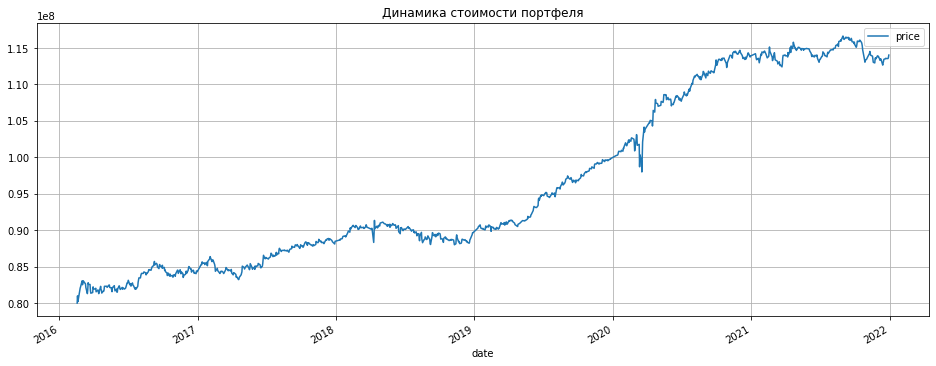

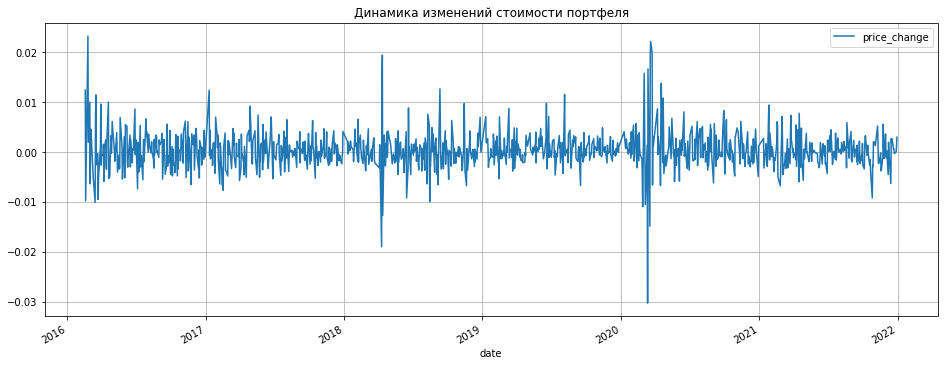

Риск-фактор: VAR 99
Кол-во пробоев: 23
Доля пробоев: 0.0216
Двухсторонняя гипотеза: 0.0009
Светофор за тест: yellow
Односторонняя гипотеза: 0.0007
Светофор за тест: yellow


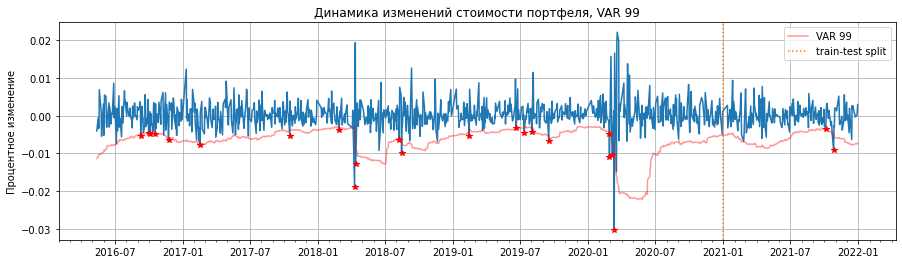

Риск-фактор: ES 97,5
Кол-во пробоев: 23
Доля пробоев: 0.0216
Двухсторонняя гипотеза: 0.0009
Светофор за тест: yellow
Односторонняя гипотеза: 0.0007
Светофор за тест: yellow


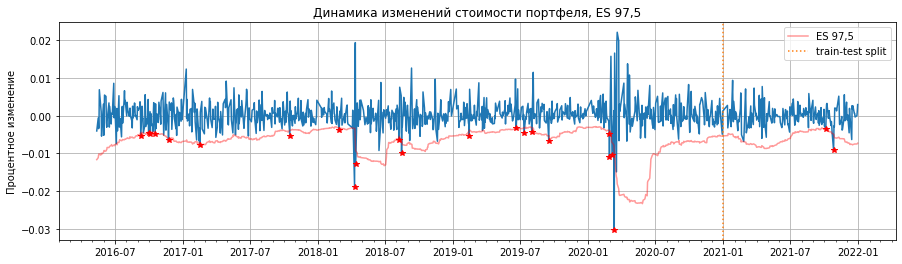

In [12]:
init_tools = {
    "APTK": 1_000_000,
    "BELU": 1_000_000,
    "FESH": 1_000_000,
    "MVID": 1_000_000,
    "NKNCP": 1_000_000,
    "PHOR": 1_000_000,
    "PIKK": 1_000_000,
    "RASP": 1_000_000,
    "SELG": 1_000_000,
    "SNGSP": 1_000_000,
    "OFZ_26207": 10_000_000,
    "OFZ_26209": 10_000_000,
    "OFZ_26211": 10_000_000,
    "OFZ_26212": 10_000_000,
    "OFZ_26218": 10_000_000,
    "USD": 10_000_000,
    "CHF": 10_000_000,
}
ps = PortfolioSimulation(init_tools, 40, 1)
ps.plot_dynamics()

ps.calc_test("var_99", "VAR 99", "r*", 0.99)
ps.calc_test("es_97,5", "ES 97,5", "r*", 0.99)

  0%|          | 0/1109 [00:00<?, ?it/s]

  0%|          | 0/17 [00:00<?, ?it/s]

  0%|          | 0/1058 [00:00<?, ?it/s]

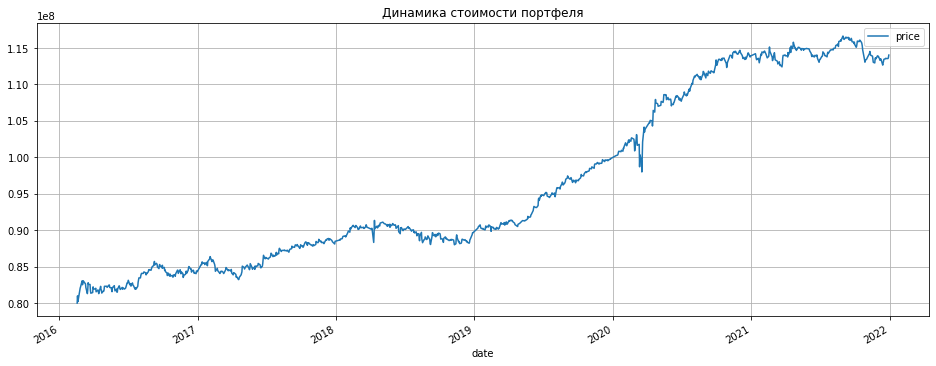

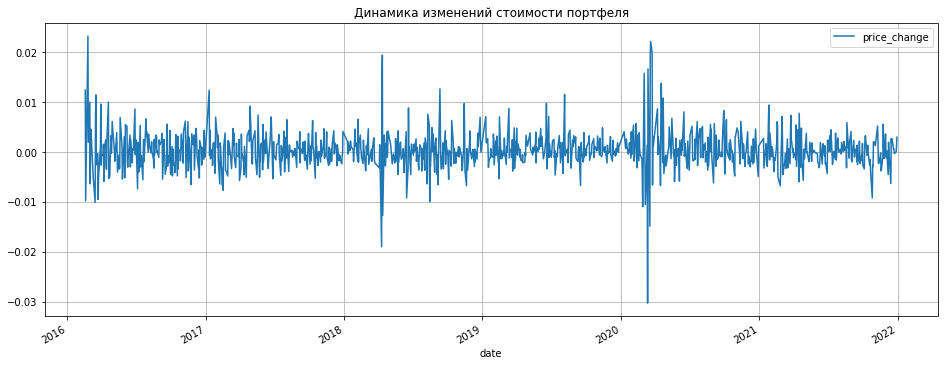

Риск-фактор: VAR 99
Кол-во пробоев: 29
Доля пробоев: 0.0274
Двухсторонняя гипотеза: 0.0
Светофор за тест: red
Односторонняя гипотеза: 0.0
Светофор за тест: red


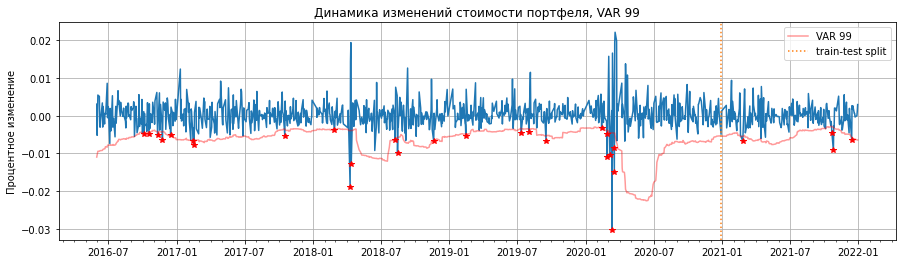

Риск-фактор: ES 97,5
Кол-во пробоев: 30
Доля пробоев: 0.0284
Двухсторонняя гипотеза: 0.0
Светофор за тест: red
Односторонняя гипотеза: 0.0
Светофор за тест: red


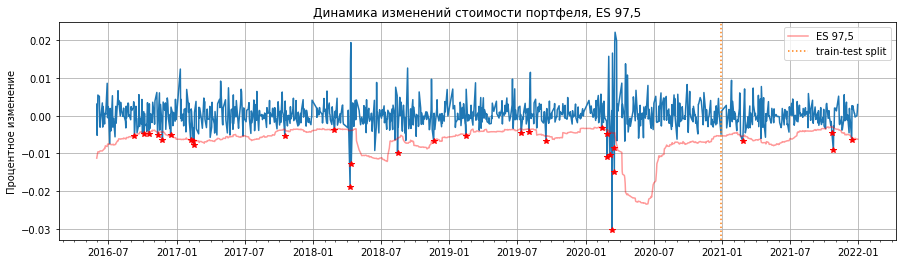

In [13]:
init_tools = {
    "APTK": 1_000_000,
    "BELU": 1_000_000,
    "FESH": 1_000_000,
    "MVID": 1_000_000,
    "NKNCP": 1_000_000,
    "PHOR": 1_000_000,
    "PIKK": 1_000_000,
    "RASP": 1_000_000,
    "SELG": 1_000_000,
    "SNGSP": 1_000_000,
    "OFZ_26207": 10_000_000,
    "OFZ_26209": 10_000_000,
    "OFZ_26211": 10_000_000,
    "OFZ_26212": 10_000_000,
    "OFZ_26218": 10_000_000,
    "USD": 10_000_000,
    "CHF": 10_000_000,
}
ps = PortfolioSimulation(init_tools, 40, 10)
ps.plot_dynamics()

ps.calc_test("var_99", "VAR 99", "r*", 0.99)
ps.calc_test("es_97,5", "ES 97,5", "r*", 0.99)

### Акции

  0%|          | 0/1109 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/1067 [00:00<?, ?it/s]

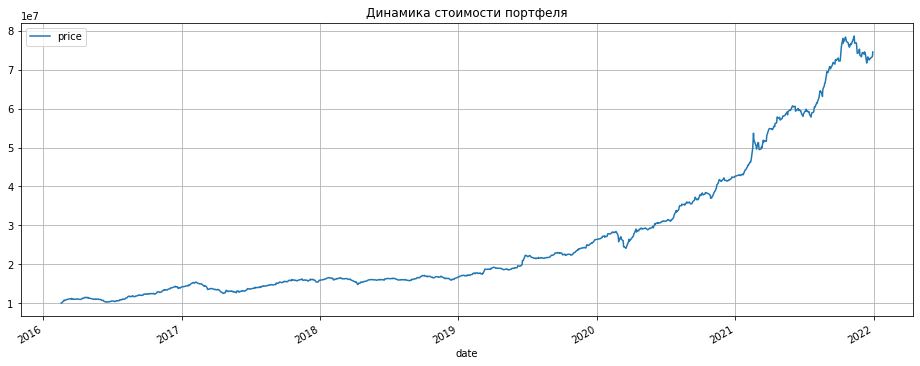

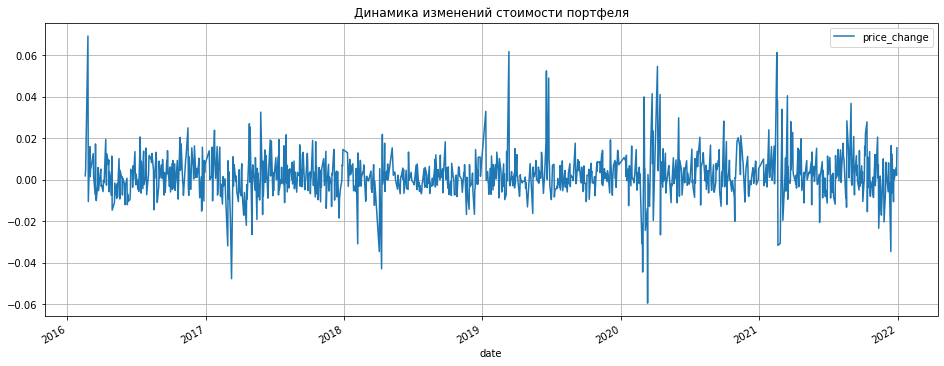

Риск-фактор: VAR 99
Кол-во пробоев: 129
Доля пробоев: 0.1209
Двухсторонняя гипотеза: 0.0
Светофор за тест: red
Односторонняя гипотеза: 0.0
Светофор за тест: red


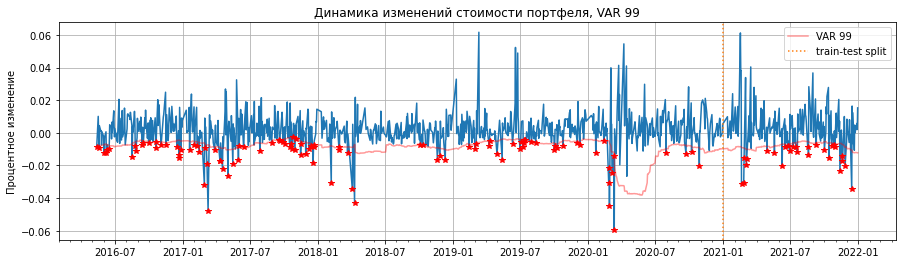

Риск-фактор: ES 97,5
Кол-во пробоев: 126
Доля пробоев: 0.1181
Двухсторонняя гипотеза: 0.0
Светофор за тест: red
Односторонняя гипотеза: 0.0
Светофор за тест: red


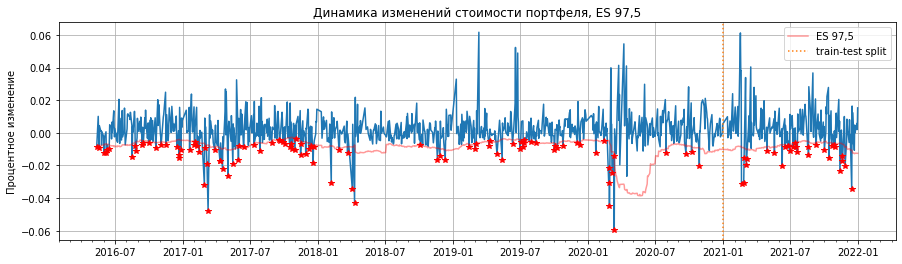

In [14]:
init_tools = {
    "APTK": 1_000_000,
    "BELU": 1_000_000,
    "FESH": 1_000_000,
    "MVID": 1_000_000,
    "NKNCP": 1_000_000,
    "PHOR": 1_000_000,
    "PIKK": 1_000_000,
    "RASP": 1_000_000,
    "SELG": 1_000_000,
    "SNGSP": 1_000_000,
}
ps = PortfolioSimulation(init_tools, 40, 1)
ps.plot_dynamics()

ps.calc_test("var_99", "VAR 99", "r*", 0.99)
ps.calc_test("es_97,5", "ES 97,5", "r*", 0.99)

  0%|          | 0/1109 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/1058 [00:00<?, ?it/s]

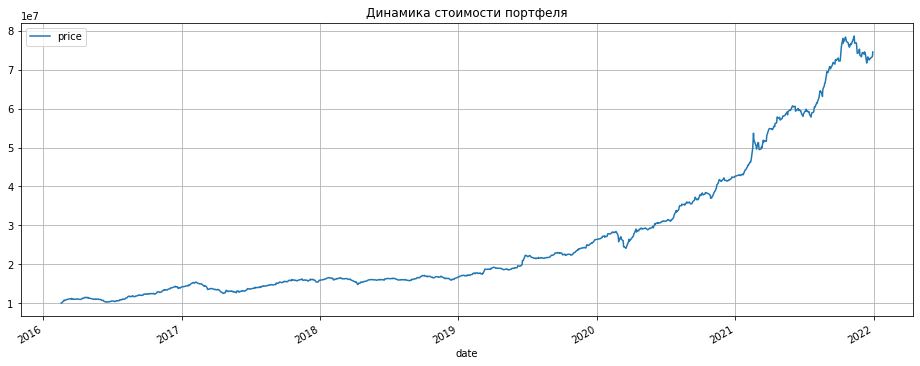

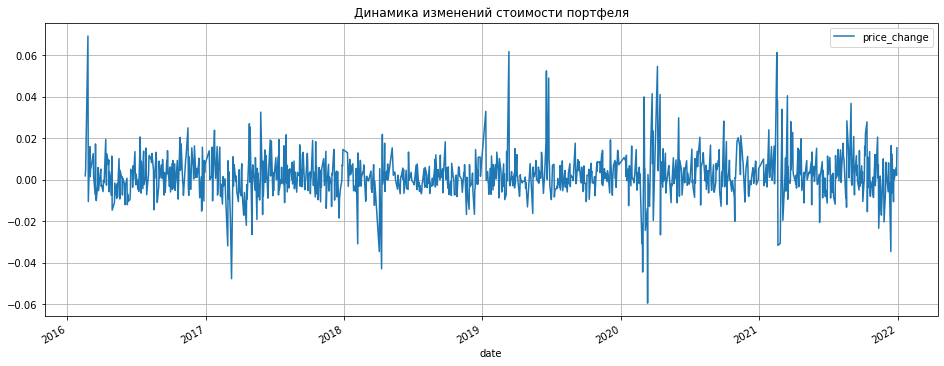

Риск-фактор: VAR 99
Кол-во пробоев: 121
Доля пробоев: 0.1144
Двухсторонняя гипотеза: 0.0
Светофор за тест: red
Односторонняя гипотеза: 0.0
Светофор за тест: red


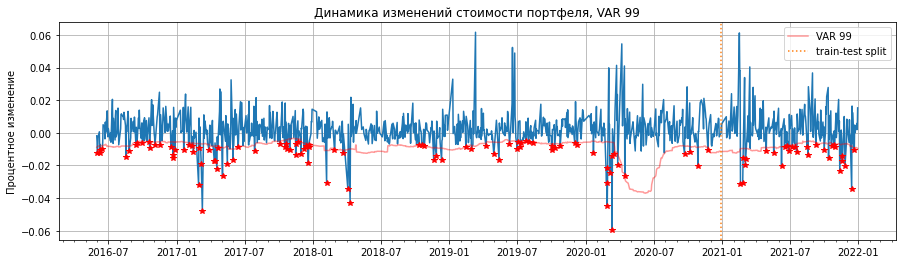

Риск-фактор: ES 97,5
Кол-во пробоев: 122
Доля пробоев: 0.1153
Двухсторонняя гипотеза: 0.0
Светофор за тест: red
Односторонняя гипотеза: 0.0
Светофор за тест: red


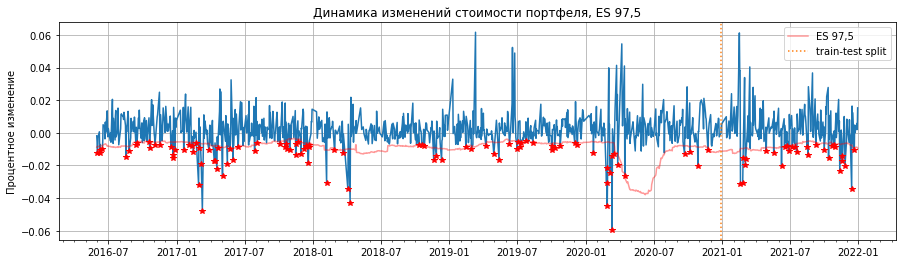

In [15]:
init_tools = {
    "APTK": 1_000_000,
    "BELU": 1_000_000,
    "FESH": 1_000_000,
    "MVID": 1_000_000,
    "NKNCP": 1_000_000,
    "PHOR": 1_000_000,
    "PIKK": 1_000_000,
    "RASP": 1_000_000,
    "SELG": 1_000_000,
    "SNGSP": 1_000_000,
}
ps = PortfolioSimulation(init_tools, 40, 10)
ps.plot_dynamics()

ps.calc_test("var_99", "VAR 99", "r*", 0.99)
ps.calc_test("es_97,5", "ES 97,5", "r*", 0.99)

### Облигации

  0%|          | 0/1109 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/1067 [00:00<?, ?it/s]

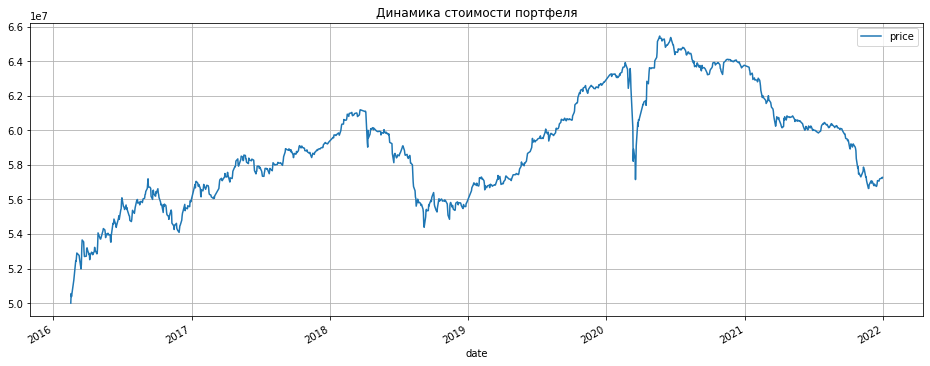

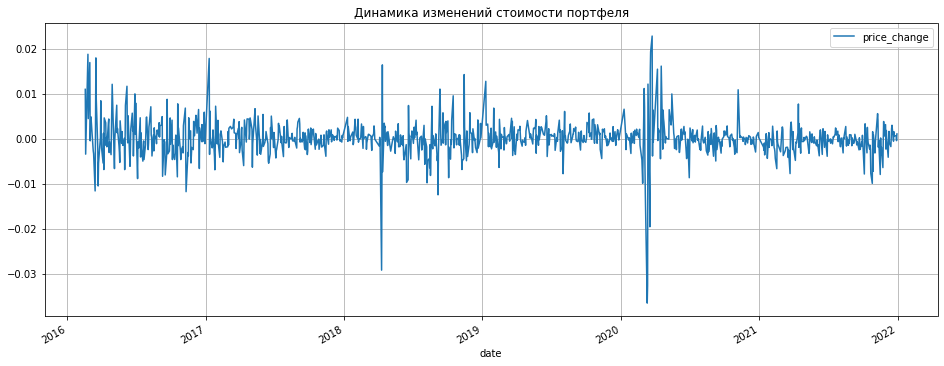

Риск-фактор: VAR 99
Кол-во пробоев: 32
Доля пробоев: 0.03
Двухсторонняя гипотеза: 0.0
Светофор за тест: red
Односторонняя гипотеза: 0.0
Светофор за тест: red


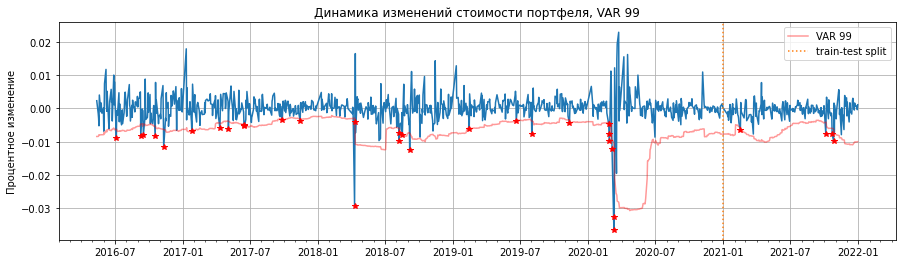

Риск-фактор: ES 97,5
Кол-во пробоев: 30
Доля пробоев: 0.0281
Двухсторонняя гипотеза: 0.0
Светофор за тест: red
Односторонняя гипотеза: 0.0
Светофор за тест: red


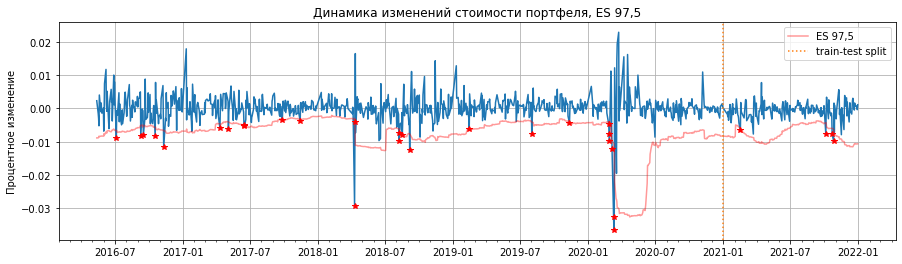

In [16]:
init_tools = {
    "OFZ_26207": 10_000_000,
    "OFZ_26209": 10_000_000,
    "OFZ_26211": 10_000_000,
    "OFZ_26212": 10_000_000,
    "OFZ_26218": 10_000_000,
}
ps = PortfolioSimulation(init_tools, 40, 1)
ps.plot_dynamics()

ps.calc_test("var_99", "VAR 99", "r*", 0.99)
ps.calc_test("es_97,5", "ES 97,5", "r*", 0.99)

  0%|          | 0/1109 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/1058 [00:00<?, ?it/s]

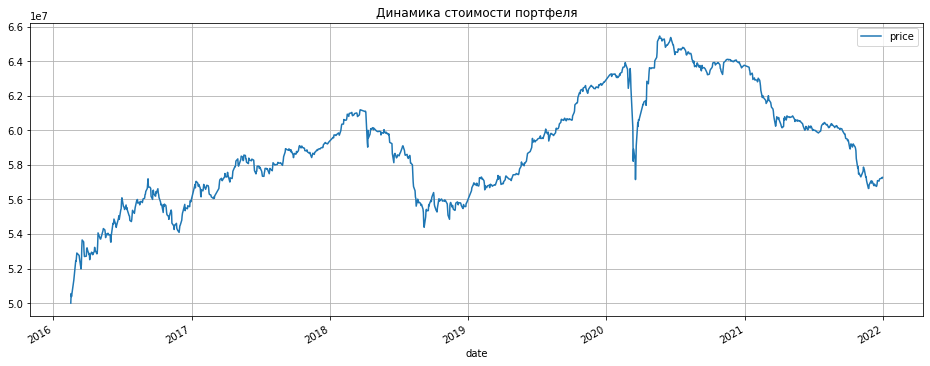

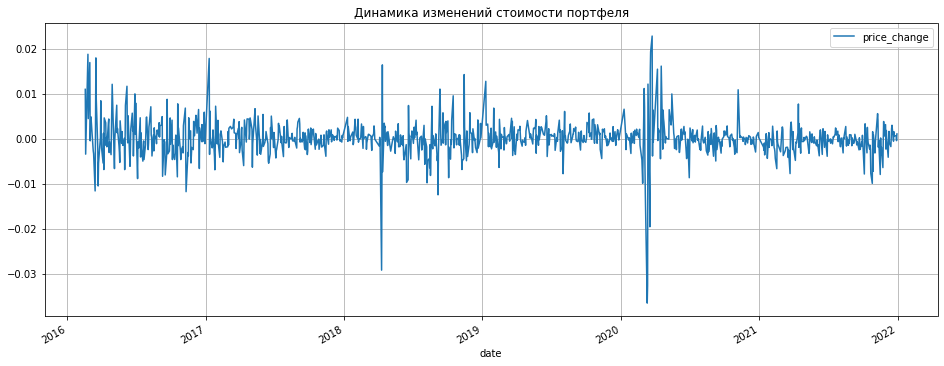

Риск-фактор: VAR 99
Кол-во пробоев: 37
Доля пробоев: 0.035
Двухсторонняя гипотеза: 0.0
Светофор за тест: red
Односторонняя гипотеза: 0.0
Светофор за тест: red


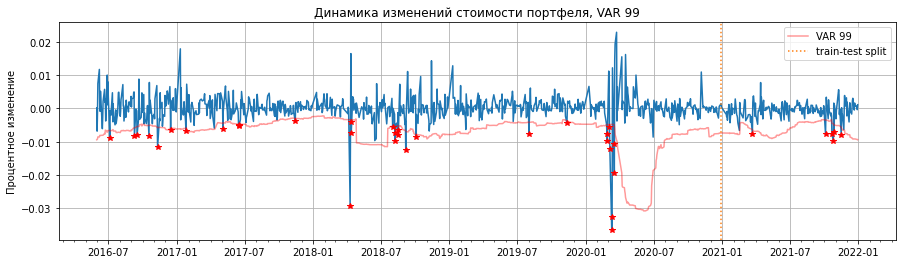

Риск-фактор: ES 97,5
Кол-во пробоев: 37
Доля пробоев: 0.035
Двухсторонняя гипотеза: 0.0
Светофор за тест: red
Односторонняя гипотеза: 0.0
Светофор за тест: red


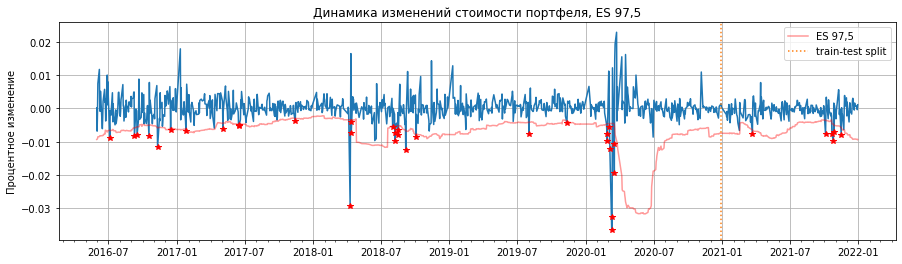

In [17]:
init_tools = {
    "OFZ_26207": 10_000_000,
    "OFZ_26209": 10_000_000,
    "OFZ_26211": 10_000_000,
    "OFZ_26212": 10_000_000,
    "OFZ_26218": 10_000_000,
}
ps = PortfolioSimulation(init_tools, 40, 10)
ps.plot_dynamics()

ps.calc_test("var_99", "VAR 99", "r*", 0.99)
ps.calc_test("es_97,5", "ES 97,5", "r*", 0.99)

### Валюта

  0%|          | 0/1109 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

  0%|          | 0/1067 [00:00<?, ?it/s]

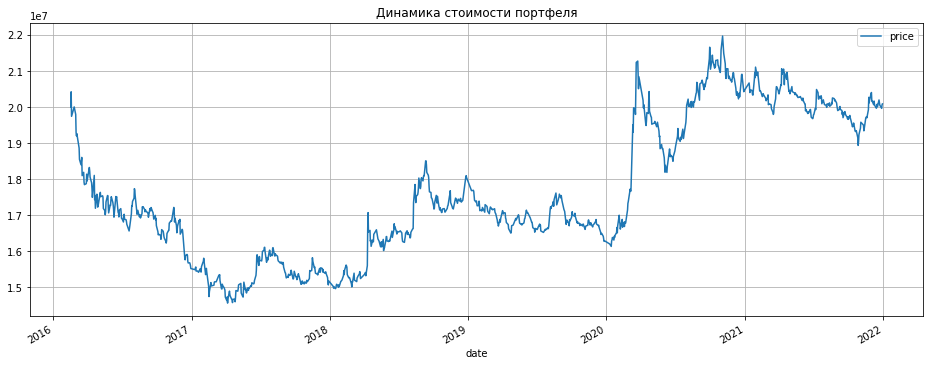

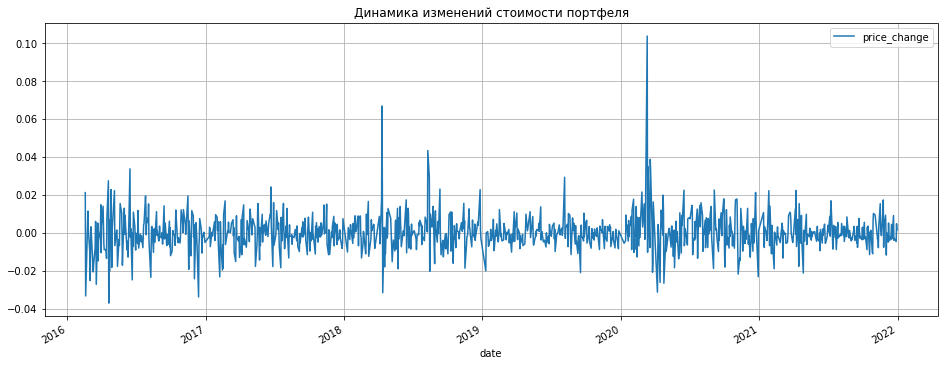

Риск-фактор: VAR 99
Кол-во пробоев: 17
Доля пробоев: 0.0159
Двухсторонняя гипотеза: 0.0623
Светофор за тест: green
Односторонняя гипотеза: 0.0439
Светофор за тест: yellow


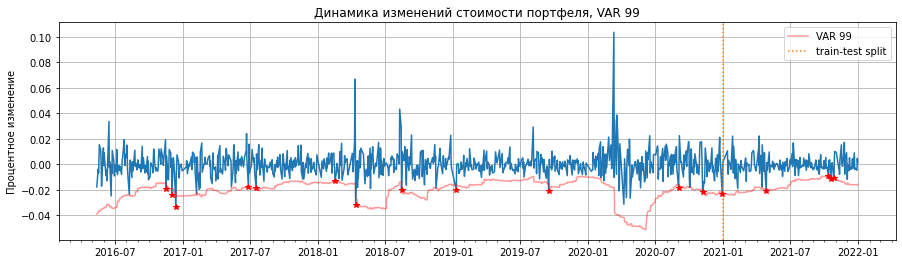

Риск-фактор: ES 97,5
Кол-во пробоев: 19
Доля пробоев: 0.0178
Двухсторонняя гипотеза: 0.0191
Светофор за тест: yellow
Односторонняя гипотеза: 0.013
Светофор за тест: yellow


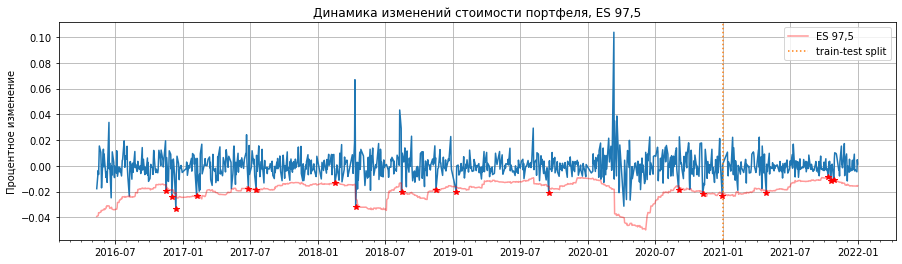

In [18]:
init_tools = {
    "USD": 10_000_000,
    "CHF": 10_000_000,
}
ps = PortfolioSimulation(init_tools, 40, 1)
ps.plot_dynamics()

ps.calc_test("var_99", "VAR 99", "r*", 0.99)
ps.calc_test("es_97,5", "ES 97,5", "r*", 0.99)

  0%|          | 0/1109 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

  0%|          | 0/1058 [00:00<?, ?it/s]

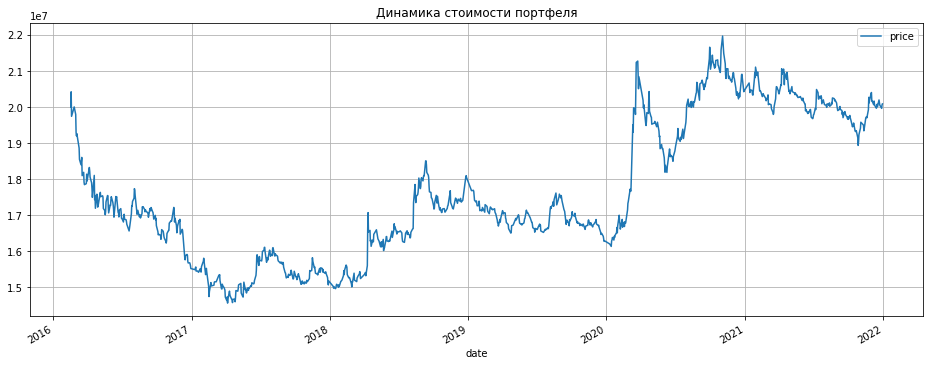

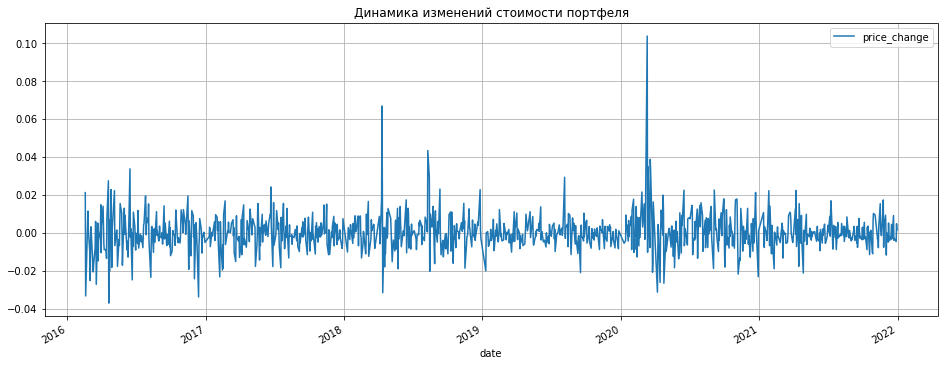

Риск-фактор: VAR 99
Кол-во пробоев: 17
Доля пробоев: 0.0161
Двухсторонняя гипотеза: 0.0607
Светофор за тест: green
Односторонняя гипотеза: 0.0411
Светофор за тест: yellow


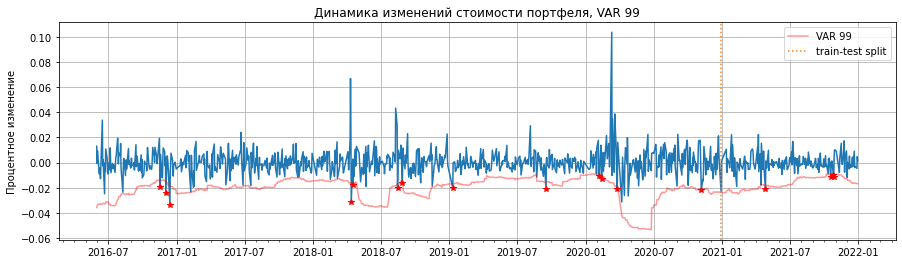

Риск-фактор: ES 97,5
Кол-во пробоев: 19
Доля пробоев: 0.018
Двухсторонняя гипотеза: 0.0185
Светофор за тест: yellow
Односторонняя гипотеза: 0.012
Светофор за тест: yellow


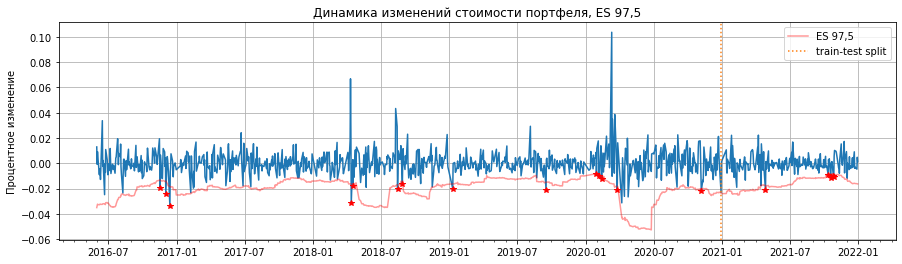

In [19]:
init_tools = {
    "USD": 10_000_000,
    "CHF": 10_000_000,
}
ps = PortfolioSimulation(init_tools, 40, 10)
ps.plot_dynamics()

ps.calc_test("var_99", "VAR 99", "r*", 0.99)
ps.calc_test("es_97,5", "ES 97,5", "r*", 0.99)